# Capital One Job Posting Analysis

Captial One has a reputation as a great place to work, the headquarters is three miles from my house, and its use of analytics is widespread throughout the company. There are always a lot of jobs posted, but without knowing the internal structure and divisions of the company, they are hard to assess given the titles alone.

## Web Scraping
Scraping job descrptions - First I read the terms and conditions of the website and also explored the robot.txt file. After confirming scraping the Capital One Career page was permissible, I searched for open jobs based on location (McLean, VA) and category in which I selected both “Analytics” and “Data Science.” This resulted in 108 jobs. I pulled the URLs into a CSV file.

I used Scrapy and a basic spider script to scrape the data. From each job posting, the program pulled the following items: url [job posting url], title [job title] , job_id  [job ID from posting], updated [date the post was updated], and text [job description text]. 

## Text Analysis


In [37]:
import re,string
import json
import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import os
import numpy as np

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

# set working file
os.chdir('/Users/rachelmartonik/MSDS_453_NLP')


In [2]:
#### Read in data ####
# Read in Job Data
import json
import pandas as pd
json_file='/Users/rachelmartonik/MSDS_453_NLP/JobPostSpider/items.jl'
jobs = pd.read_json(json_file, lines=True)

jobs.head()

,job_id,text,title,updated,url
0,"[Job ID, R90676]","Recruiting: VA - McLean, United States of Amer...",Data Scientist,"[Updated date, 01/17/2020]",https://www.capitalonecareers.com/job/mclean/d...
1,"[Job ID, R90624]","McLean 2 (19052), United States of America, Mc...","Data Scientist, Card DS+","[Updated date, 01/17/2020]",https://www.capitalonecareers.com/job/mclean/d...
2,"[Job ID, R90625]","McLean 2 (19052), United States of America, Mc...","Data Scientist, Small Business Card","[Updated date, 01/17/2020]",https://www.capitalonecareers.com/job/mclean/d...
3,"[Job ID, R90483]","77 West Wacker Dr (35012), United States of Am...","Senior Associate, Data Scientist, Card DS+","[Updated date, 01/16/2020]",https://www.capitalonecareers.com/job/chicago/...
4,"[Job ID, R90548]","McLean 2 (19052), United States of America, Mc...","Data Scientist, Digital Machine Learning","[Updated date, 01/16/2020]",https://www.capitalonecareers.com/job/mclean/d...


In [3]:
# Get rid of job_id and updated lists
jobs = jobs.applymap(lambda x: x[1] if isinstance(x, list) else x)
jobs.head()

,job_id,text,title,updated,url
0,R90676,"Recruiting: VA - McLean, United States of Amer...",Data Scientist,01/17/2020,https://www.capitalonecareers.com/job/mclean/d...
1,R90624,"McLean 2 (19052), United States of America, Mc...","Data Scientist, Card DS+",01/17/2020,https://www.capitalonecareers.com/job/mclean/d...
2,R90625,"McLean 2 (19052), United States of America, Mc...","Data Scientist, Small Business Card",01/17/2020,https://www.capitalonecareers.com/job/mclean/d...
3,R90483,"77 West Wacker Dr (35012), United States of Am...","Senior Associate, Data Scientist, Card DS+",01/16/2020,https://www.capitalonecareers.com/job/chicago/...
4,R90548,"McLean 2 (19052), United States of America, Mc...","Data Scientist, Digital Machine Learning",01/16/2020,https://www.capitalonecareers.com/job/mclean/d...


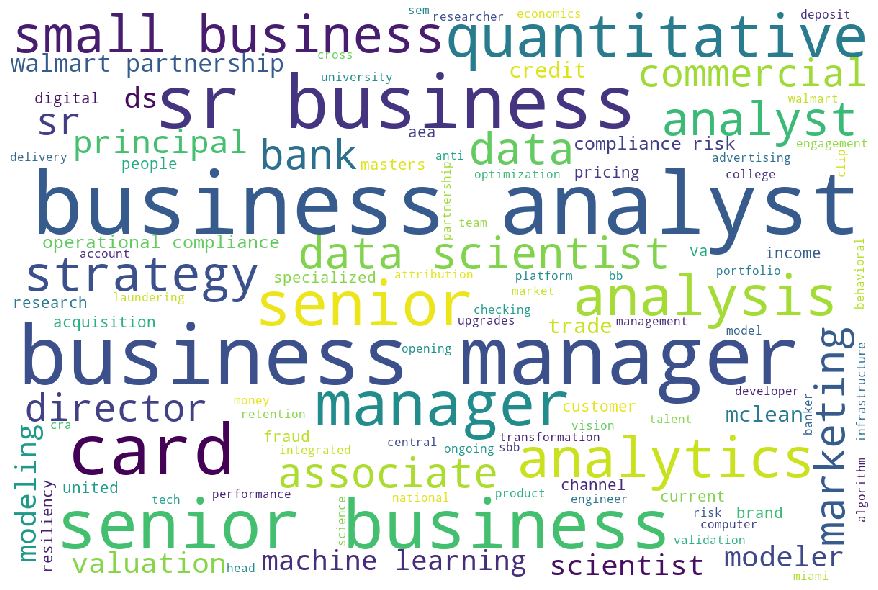

In [5]:
#### Word cloud of job titles ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in jobs.title: 
     
   # typecaste each val to string 
   val = str(val) 
 
   # split the value 
   tokens = val.split() 
     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
 
 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords, 
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('job title word cloud.png')
plt.show() 


In [8]:
data = jobs
#print to show the first and last 10 documents
print('\nGlimpse of beginning of corpus data frame:\n')
print(data.head(10))


Glimpse of beginning of corpus data frame:

    job_id                                               text  \
0   R90676  Recruiting: VA - McLean, United States of Amer...   
1   R90624  McLean 2 (19052), United States of America, Mc...   
2   R90625  McLean 2 (19052), United States of America, Mc...   
3   R90483  77 West Wacker Dr (35012), United States of Am...   
4   R90548  McLean 2 (19052), United States of America, Mc...   
5   R90484  West Creek 8 (12080), United States of America...   
6   R90472  McLean 2 (19052), United States of America, Mc...   
7   R90486  McLean 2 (19052), United States of America, Mc...   
8   R90309  McLean 1 (19050), United States of America, Mc...   
9   R90390  Recruiting: VA - McLean, United States of Amer...   

                                               title      updated  \
0                                     Data Scientist   01/17/2020   
1                           Data Scientist, Card DS+   01/17/2020   
2                Data Scientist,

In [14]:
print(data['text'][3])

77 West Wacker Dr (35012), United States of America, Chicago, IllinoisAt Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.                                               Guided by our shared values, we thrive in an environment where collaboration and openness are valued. We believe that innovation is powered by perspective and that teamwork and respect for each other lead to superior results. We elevate each other and obsess about doing the right thing. Our associates serve with humility and a deep respect for their responsibility in helping our customers achieve their goals and realize their dreams. Together, we are on a quest to change

In [30]:
#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)

In [32]:
#### Remove generic Cap 1 description and EEOE legal text at end 
 #for loop to shorten the text with repeated EEOE stuff at the bottom
shortened_text1=[]
for i in text_body:
    text= i.rsplit('Capital One will consider',)[0]
    shortened_text1.append(text)

print(shortened_text1[0])

Recruiting: VA - McLean, United States of America, McLean, VirginiaAt Capital One, we’re building a leading information-based technology company. Still founder-led by Chairman and Chief Executive Officer Richard Fairbank, Capital One is on a mission to help our customers succeed by bringing ingenuity, simplicity, and humanity to banking. We measure our efforts by the success our customers enjoy and the advocacy they exhibit. We are succeeding because they are succeeding.                                               Guided by our shared values, we thrive in an environment where collaboration and openness are valued. We believe that innovation is powered by perspective and that teamwork and respect for each other lead to superior results. We elevate each other and obsess about doing the right thing. Our associates serve with humility and a deep respect for their responsibility in helping our customers achieve their goals and realize their dreams. Together, we are on a quest to change ba

In [33]:
# Cut off the first Cap 1 paragraph
shortened_text=[]
for i in shortened_text1:
    text= i.rsplit('financial lives.', )[-1]
    shortened_text.append(text)
    
print(shortened_text[0])

Role DescriptionIn this role, you will:Partner with a cross-functional team of data scientists, software engineers, and product managers to deliver a product customers loveLeverage a broad stack of technologies — Python, Conda, AWS, H2O, Spark, and more — to reveal the insights hidden within huge volumes of numeric and textual dataBuild machine learning models through all phases of development, from design through training, evaluation, validation, and implementationFlex your interpersonal skills to translate the complexity of your work into tangible business goalsThe Ideal Candidate is:Customer first. You love the process of analyzing and creating, but also share our passion to do the right thing. You know at the end of the day it’s about making the right decision for our customers.Innovative. You continually research and evaluate emerging technologies. You stay current on published state-of-the-art methods, technologies, and applications and seek out opportunities to apply them.Creati

In [38]:
# Settings for vectorization
STEMMING = False  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # Experiment with n-gram length
VECTOR_LENGTH = 1000  # set vector length for TF-IDF and Doc2Vec

In [39]:
# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

In [40]:
# Create empty list to store text documents labels (job titles)
labels=[]

# Append job titles to label list
for i in range(0,len(data)):
    temp_text=data['title'].iloc[i]
    labels.append(temp_text)
     
# Create empty list to store processed documents
processed_text=[]

# Process documents
for i in shortened_text:
    text=clean_doc(i)
    processed_text.append(text)


In [42]:
#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
type(final_processed_text)
#the following is an example of what the processed text looks like.  
print('\nExample of what one parsed document looks like:\n')
print(final_processed_text[0])


Example of what one parsed document looks like:

role descriptionin role willpartner crossfunctional team data scientists software engineers product managers deliver product customers loveleverage broad stack technologies python conda aws spark reveal insights hidden within huge volumes numeric textual databuild machine learning models phases development design training evaluation validation implementationflex interpersonal skills translate complexity work tangible business goalsthe ideal candidate iscustomer first love process analyzing creating also share passion right thing know end day making right decision customersinnovative continually research evaluate emerging technologies stay current published stateoftheart methods technologies applications seek opportunities apply themcreative thrive bringing definition big undefined problems love asking questions pushing hard find answers afraid share new ideaa leader challenge conventional thinking work stakeholders identify improve stat

In [43]:
### Sklearn TFIDF 
#note the ngram_range will allow you to include multiple-word tokens within the TFIDF matrix
#Call Tfidf Vectorizer
print('\nWorking on TF-IDF vectorization')
Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names(), index = labels)

matrix.to_csv('tfidf-matrix.csv')
print('\nTF-IDF vectorization complete, matrix saved to tfidf-matrix.csv')



Working on TF-IDF vectorization

TF-IDF vectorization complete, matrix saved to tfidf-matrix.csv


In [47]:
# Explore TFIDF Values
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF = pd.DataFrame(average_TFIDF,index = [0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

average_TFIDF_DF.head(25)

,TFIDF
ability,0.025865
ability build,0.011084
ability drive,0.016582
able,0.038462
able bring,0.015579
able consistently,0.011542
able drive,0.015835
accountable,0.012314
accountable able,0.011542
achieve,0.020976


In [48]:
#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list = average_TFIDF_DF[average_TFIDF_DF['TFIDF'] >= outlier]

#can export matrix to csv and explore further if necessary
features = matrix.columns
features

Index(['ability', 'ability build', 'ability drive', 'able', 'able bring',
       'able consistently', 'able drive', 'accountable', 'accountable able',
       'achieve',
       ...
       'written', 'written oral', 'year', 'year experience', 'years',
       'years experience', 'yet', 'yet responsible', 'youll', 'youll team'],
      dtype='object', length=1000)